In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")

import motiflets.motiflets as ml
from motiflets.competitors import *
from motiflets.plotting import *

import subprocess
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import warnings
warnings.simplefilter("ignore")

#  Load Muscle Activation Dataset

Dataset Original Length n:  14950
Dataset Sampled Length n:  14950
../datasets/ground_truth/muscle_activation_gt.csv


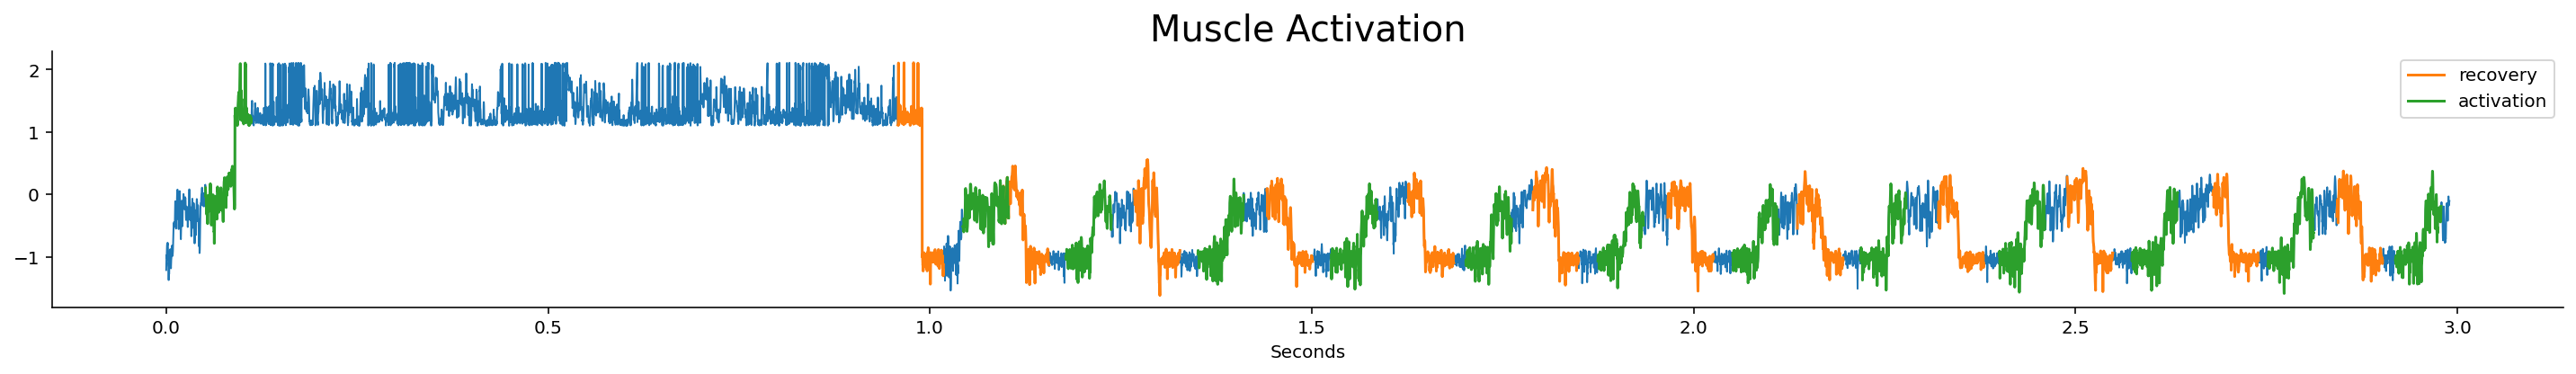

In [2]:
file = 'muscle_activation.csv'
ds_name = "Muscle Activation"
series, df_gt = ml.read_dataset_with_index(file)
data = series.values
# series = ml.as_series(data, np.arange(0, 29899, 2) / 10000, 'Seconds')
plot_dataset(file, series, ds_name=ds_name, ground_truth=df_gt)

# Parameters

In [3]:
df = pd.DataFrame() # TOP-1
df2 = pd.DataFrame() # TOP-2

rerun_all_jars = False
ks = 15
dataset = os.getcwd() + '/../datasets/original/' + file
print(dataset, len(series))

/Users/bzcschae/workspace/motiflets/notebooks/../datasets/muscle_activation.csv 14950


# k-Motiflets

## First, we learn the motif length l

Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:04<00:00,  2.83it/s]


Motif Length: 200 	 0.04 	AU_PEF: 0.212 	#Elbows: 3


Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.23it/s]


Motif Length: 250 	 0.05 	AU_PEF: 0.212 	#Elbows: 1


Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


Motif Length: 300 	 0.06 	AU_PEF: 0.179 	#Elbows: 2


Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:03<00:00,  3.78it/s]


Motif Length: 350 	 0.07 	AU_PEF: 0.185 	#Elbows: 2


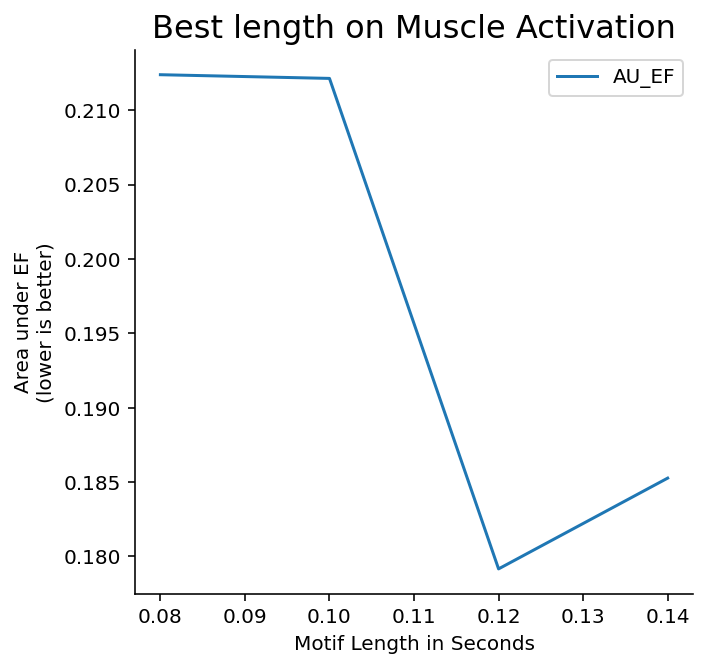

Found motif length 600


In [4]:
length_range = np.arange(400,701,100) 
motif_length = plot_motif_length_selection(
    ks, series, file, length_range, ds_name=ds_name)

print ("Found motif length", motif_length)

## Next, we learn the size k of the motif set

Compute ks: 100%|██████████████████████████████████████████████████| 13/13 [00:12<00:00,  1.04it/s]


Chosen window-size: 600
Identified Elbow Points [ 9 12]
Filtered Elbow Points [12]


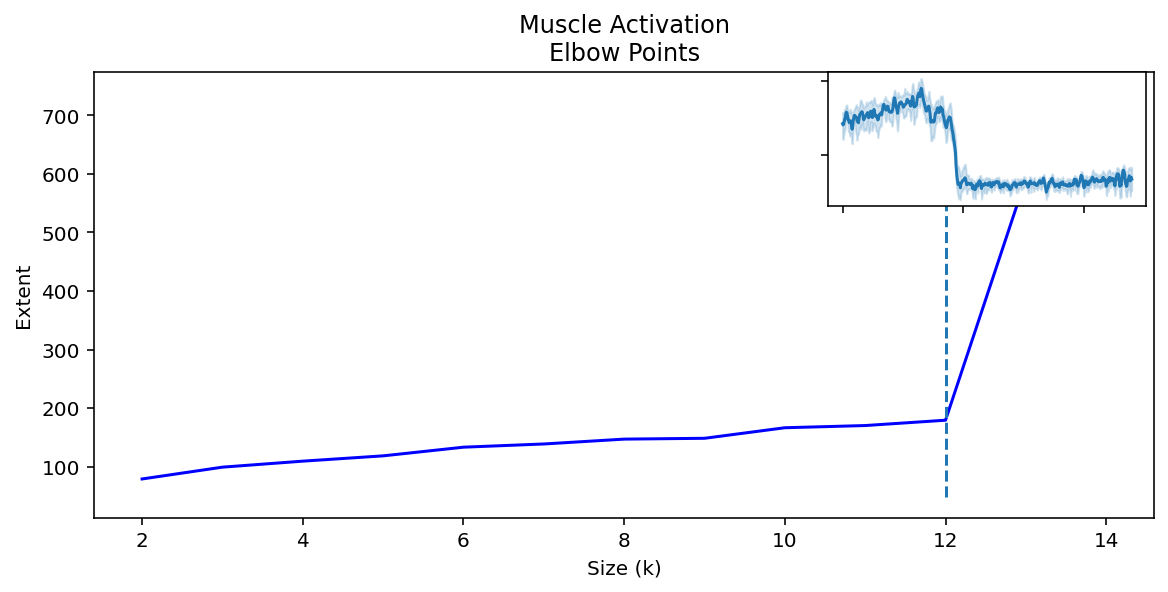

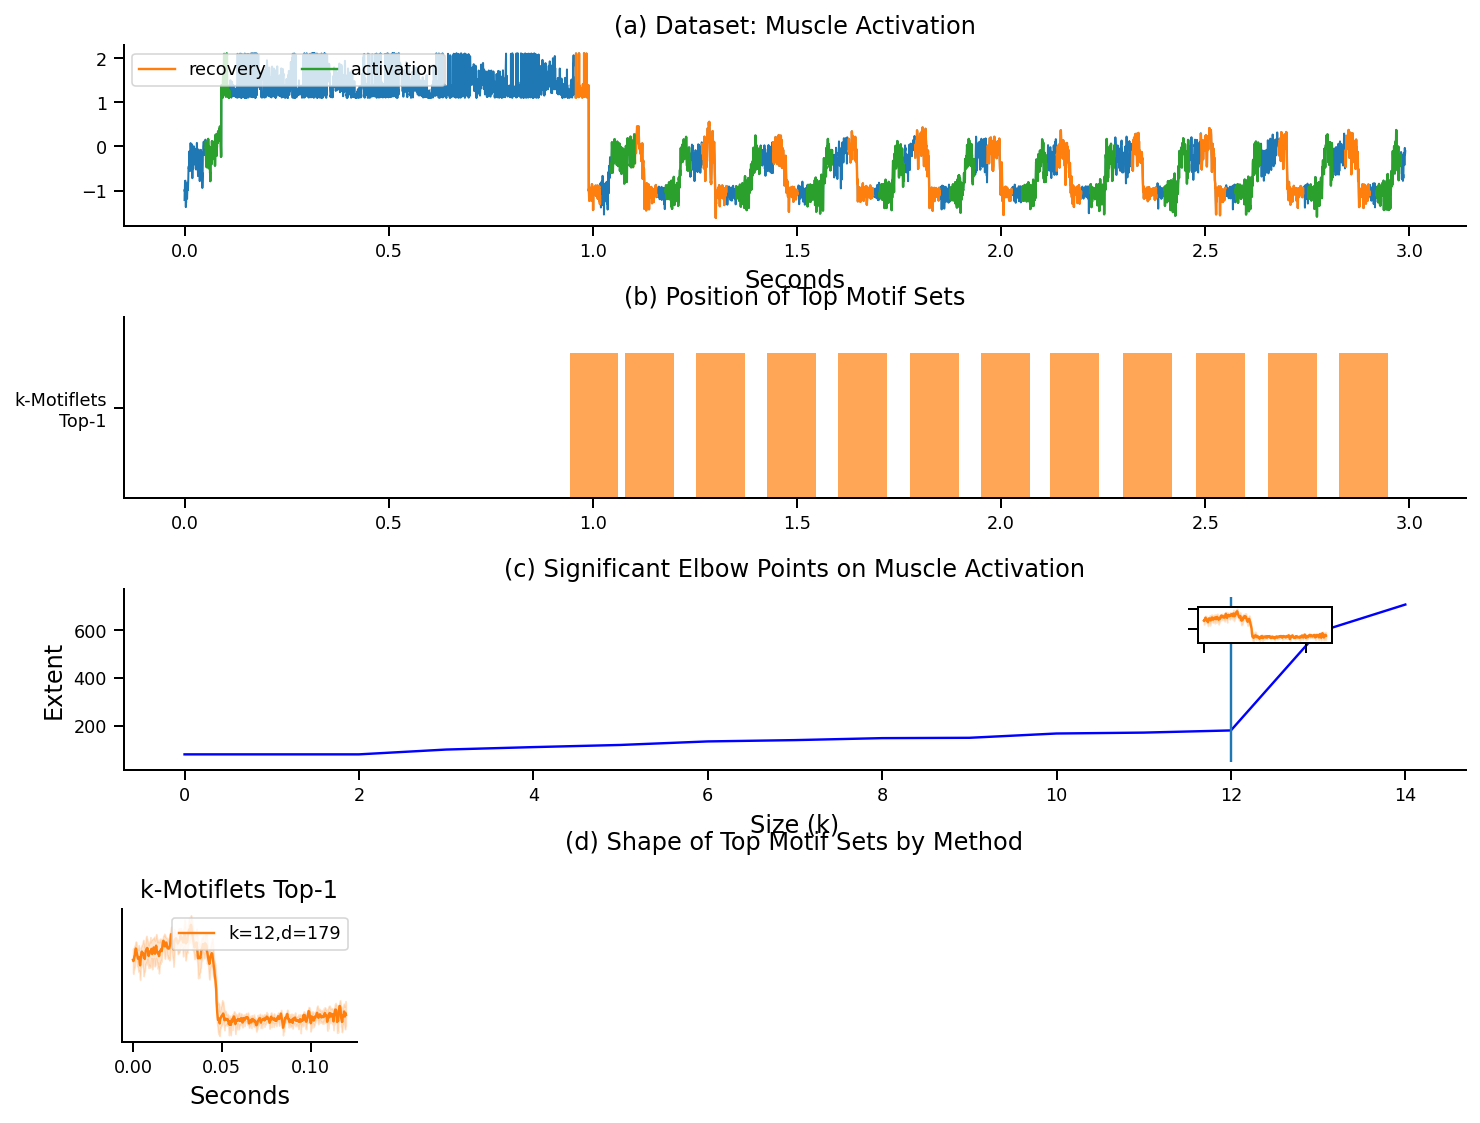

In [5]:
dists, motiflets, elbow_points = plot_elbow(
    ks, series, file, ds_name=ds_name, plot_elbows=True, 
    motif_length=motif_length, method_name="k-Motiflets", ground_truth=df_gt)

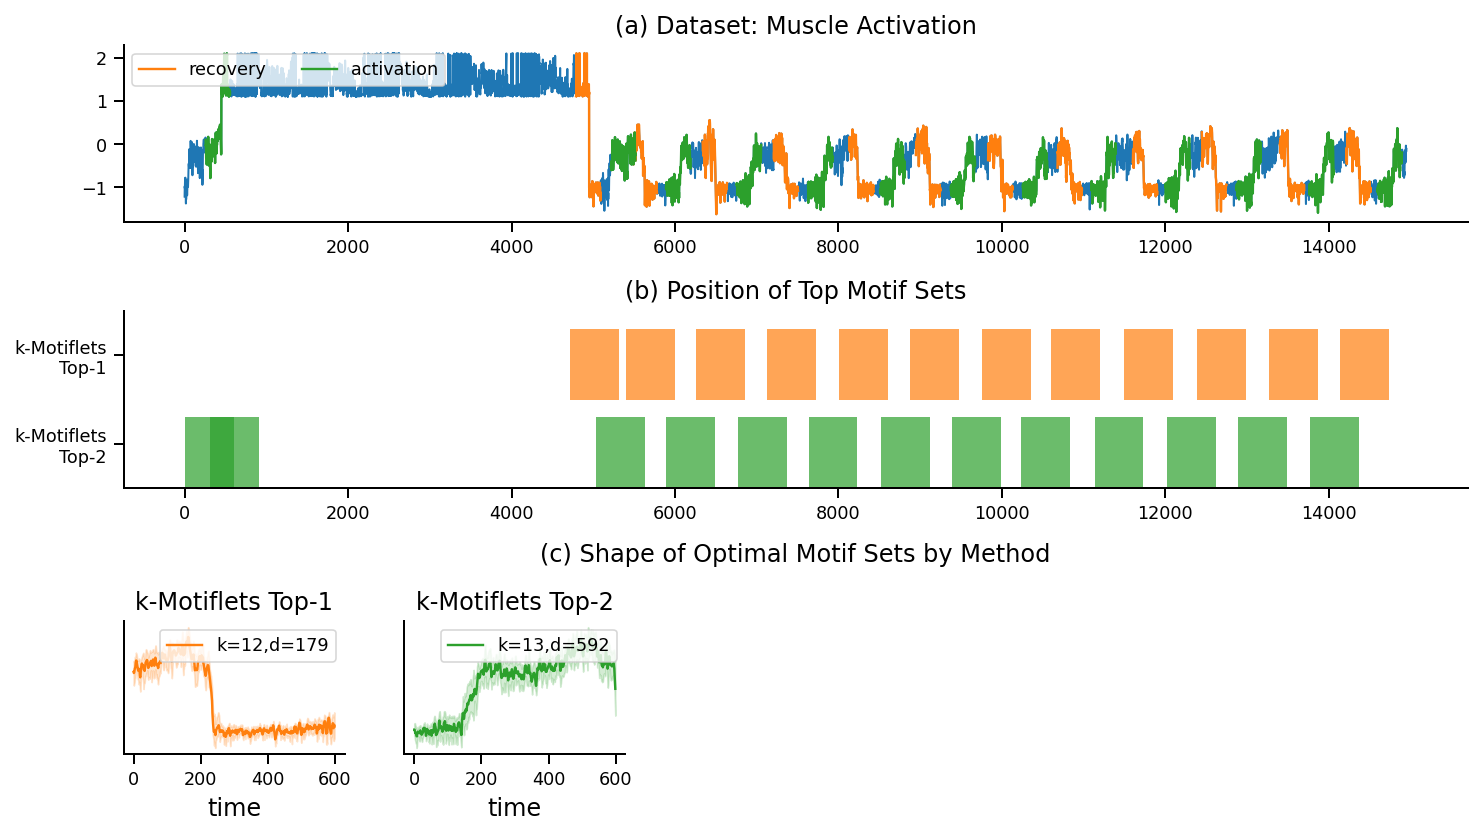

In [6]:
# 13 is no elbow point, thus we add it manually
elbow_points = [12, 13]
                
plot_grid_motiflets(
        file, data, motiflets, elbow_points,
        dists, motif_length, ds_name=ds_name, show_elbows=False,
        ground_truth=df_gt, method_name="k-Motiflets")

In [7]:
D_full = ml.compute_distances_full(data, motif_length)

df["Motiflets Top-1"] = [motiflets[elbow_points[-1]]]
df2["Motiflets Top-2"] = [motiflets[elbow_points[-2]]]

r_top1 = ml.get_radius(D_full, motiflets[elbow_points[-1]])
r_top2 = ml.get_radius(D_full, motiflets[elbow_points[-2]])

print("Radius of TOP-1 Motif", r_top1, r_top2)
print("Extent of TOP-1 Motif", ml.get_pairwise_extent(D_full, motiflets[elbow_points[-1]]))

Radius of TOP-1 Motif 400.98760986328125 153.02577209472656
Extent of TOP-1 Motif 592.0465698242188


# Oracle

The competitor methods have two input parameters: length l and the radius r. These have to be tuned using trial-and-error. We pretend to have an oracle on the length l and the radius r. But sometimes this oracle is off by just 10% on both parameters to reflect human trial-and-error.

In [8]:
radii = np.array([r_top2, r_top1])
print("Radii r", radii)

print("Best Radii\t", radii)
print("Best Lengths\t", motif_length)

# Human error due to trial-and-error
errors = [0, -0.10, 0.10]

Radii r [153.02577209 400.98760986]
Best Radii	 [153.02577209 400.98760986]
Best Lengths	 600


# Set Finder
Runs java code:
- https://sites.google.com/site/timeseriesmotifsets/

In [9]:
rs = np.array([r_top2 * 2.5, r_top1 * 1.145])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/set_finder.jar',
           dataset,
           'SetFinder',
           str(list(rs)),
           str(mls)])

,offsets
SF Top-1,"[7, 5600, 6473, 7353, 8219, 9088, 9977, 10818,..."
SF Top-1 -10%,"[5, 5601, 6474, 7356, 8220, 9088, 9977, 10819,..."
SF Top-1 +10%,"[8512, 270, 4948, 5641, 5911, 6502, 6772, 7427..."
SF Top-2,"[8493, 300, 4956, 5680, 6546, 7556, 9186, 1005..."
SF Top-2 -10%,"[13898, 5134, 6004, 6868, 7752, 8613, 9501, 10..."
SF Top-2 +10%,"[90, 5640, 6512, 7419, 7689, 8261, 8531, 9118,..."


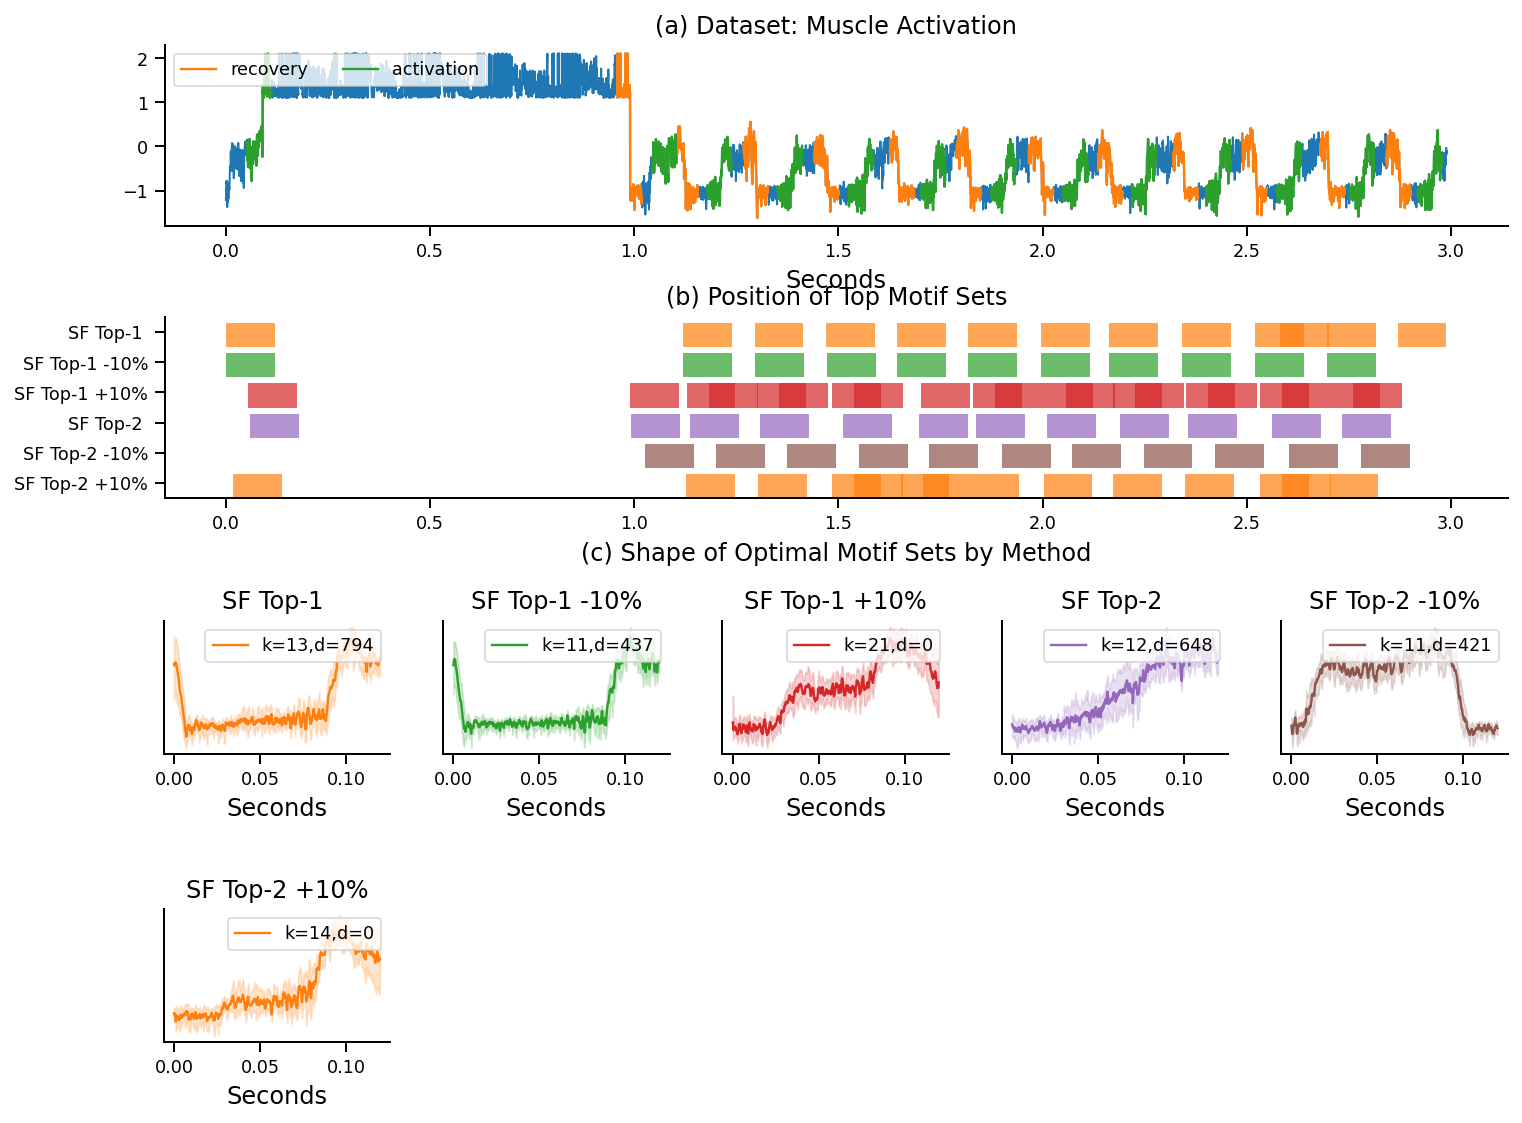

In [10]:
# run jave code first       
ms_all = {
    "" : [
    [8493, 300, 4956, 5680, 6546, 7556, 9186, 10054, 10952, 11782, 12813, 13670], 
    [7, 5600, 6473, 7353, 8219, 9088, 9977, 10818, 11709, 12603, 12903, 13485, 14347],
    ], 
    "-10%" :[
    [13898, 5134, 6004, 6868, 7752, 8613, 9501, 10360, 11237, 12114, 13015],
    [5, 5601, 6474, 7356, 8220, 9088, 9977, 10819, 11711, 12604, 13486],
    ],   
    "+10%" :[
	[90, 5640, 6512, 7419, 7689, 8261, 8531, 9118, 10012, 10865, 11748, 12658, 12932, 13515],
	[8512, 270, 4948, 5641, 5911, 6502, 6772, 7427, 7697, 9147, 9417, 10013, 10283, 10864, 11134, 11760, 12030, 12663, 12933, 13529, 13799],
    ]
}

df_all_1  = pd.DataFrame()
df_all_2  = pd.DataFrame()
for key in ms_all:       
    ms_set_finder = ms_all[key]
    df_all_1["SF Top-1 " + key] = [ms_set_finder[-1]]
    df_all_2["SF Top-2 " + key] = [ms_set_finder[-2]]

    df["SF Top-1 " + key] = [ms_set_finder[-1]]
    df2["SF Top-2 " + key] = [ms_set_finder[-2]]

    
df_all = (pd.concat([df_all_1, df_all_2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
display(df_all)

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length,
                     method_names=df_all.index.values, ground_truth=df_gt)

# EMMA

Runs Java Code
- https://github.com/jMotif/SAX

In [11]:
rs = np.array([r_top2 * 2.8, r_top1 * 1.145])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/emma.jar',
           dataset,
           str(list(rs)),
           str(mls)])

,offsets
EMMA Top-1,"[0, 300, 4943, 5622, 6489, 7385, 9112, 9997, 1..."
EMMA Top-1 -10%,"[4950, 5620, 6488, 7383, 8237, 9105, 9990, 108..."
EMMA Top-1 +10%,"[0, 270, 4945, 5629, 5899, 6496, 6766, 7402, 7..."
EMMA Top-2,"[0, 300, 4942, 5621, 6491, 7383, 9112, 9993, 1..."
EMMA Top-2 -10%,"[5621, 6488, 7390, 8237, 9107, 9993, 10840, 11..."
EMMA Top-2 +10%,"[0, 270, 4949, 5663, 5933, 6517, 6787, 7430, 7..."


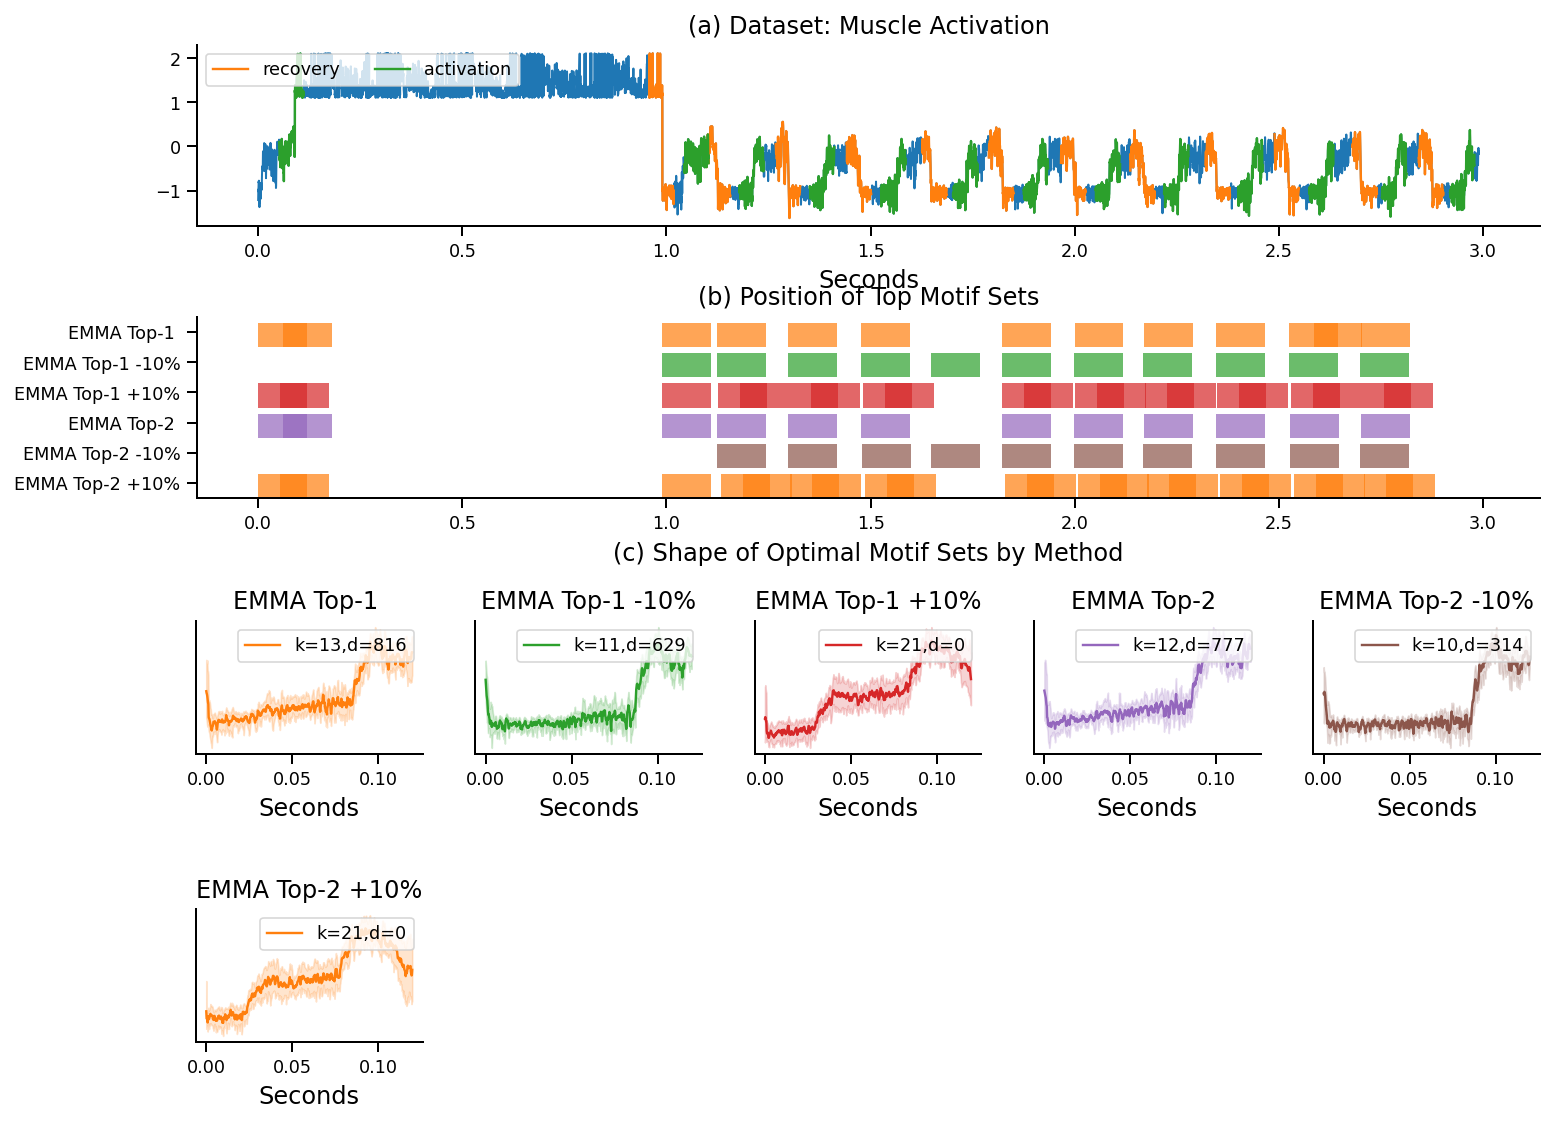

In [12]:
# run jave code first       
ms_all = {
    "" : [
    [0, 300, 4942, 5621, 6491, 7383, 9112, 9993, 10846, 11732, 12641, 13506],
    [0, 300, 4943, 5622, 6489, 7385, 9112, 9997, 10847, 11731, 12624, 12924, 13508],    
    ], 
    "-10%" :[
	[5621, 6488, 7390, 8237, 9107, 9993, 10840, 11729, 12631, 13498],
	[4950, 5620, 6488, 7383, 8237, 9105, 9990, 10840, 11729, 12624, 13495],        
    ],
    "+10%" :[
    [0, 270, 4949, 5663, 5933, 6517, 6787, 7430, 7700, 9144, 9414, 10038, 10308, 10888, 11158, 11774, 12044, 12681, 12951, 13539, 13809],
	[0, 270, 4945, 5629, 5899, 6496, 6766, 7402, 7672, 9112, 9382, 10006, 10276, 10860, 11130, 11739, 12009, 12646, 12916, 13517, 13787],        
    ],    
}

df_all_1  = pd.DataFrame()
df_all_2  = pd.DataFrame()
for key in ms_all:       
    ms_learning_motifs = ms_all[key]
    df_all_1["EMMA Top-1 " + key] = [ms_learning_motifs[-1]]
    df_all_2["EMMA Top-2 " + key] = [ms_learning_motifs[-2]]

    df["EMMA Top-1 " + key] = [ms_learning_motifs[-1]]
    df2["EMMA Top-2 " + key] = [ms_learning_motifs[-2]]

    
df_all = (pd.concat([df_all_1, df_all_2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
display(df_all)

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length,
                     method_names=df_all.index.values, ground_truth=df_gt)

# Valmod Motif Sets
based on own (fixed-length) implementation

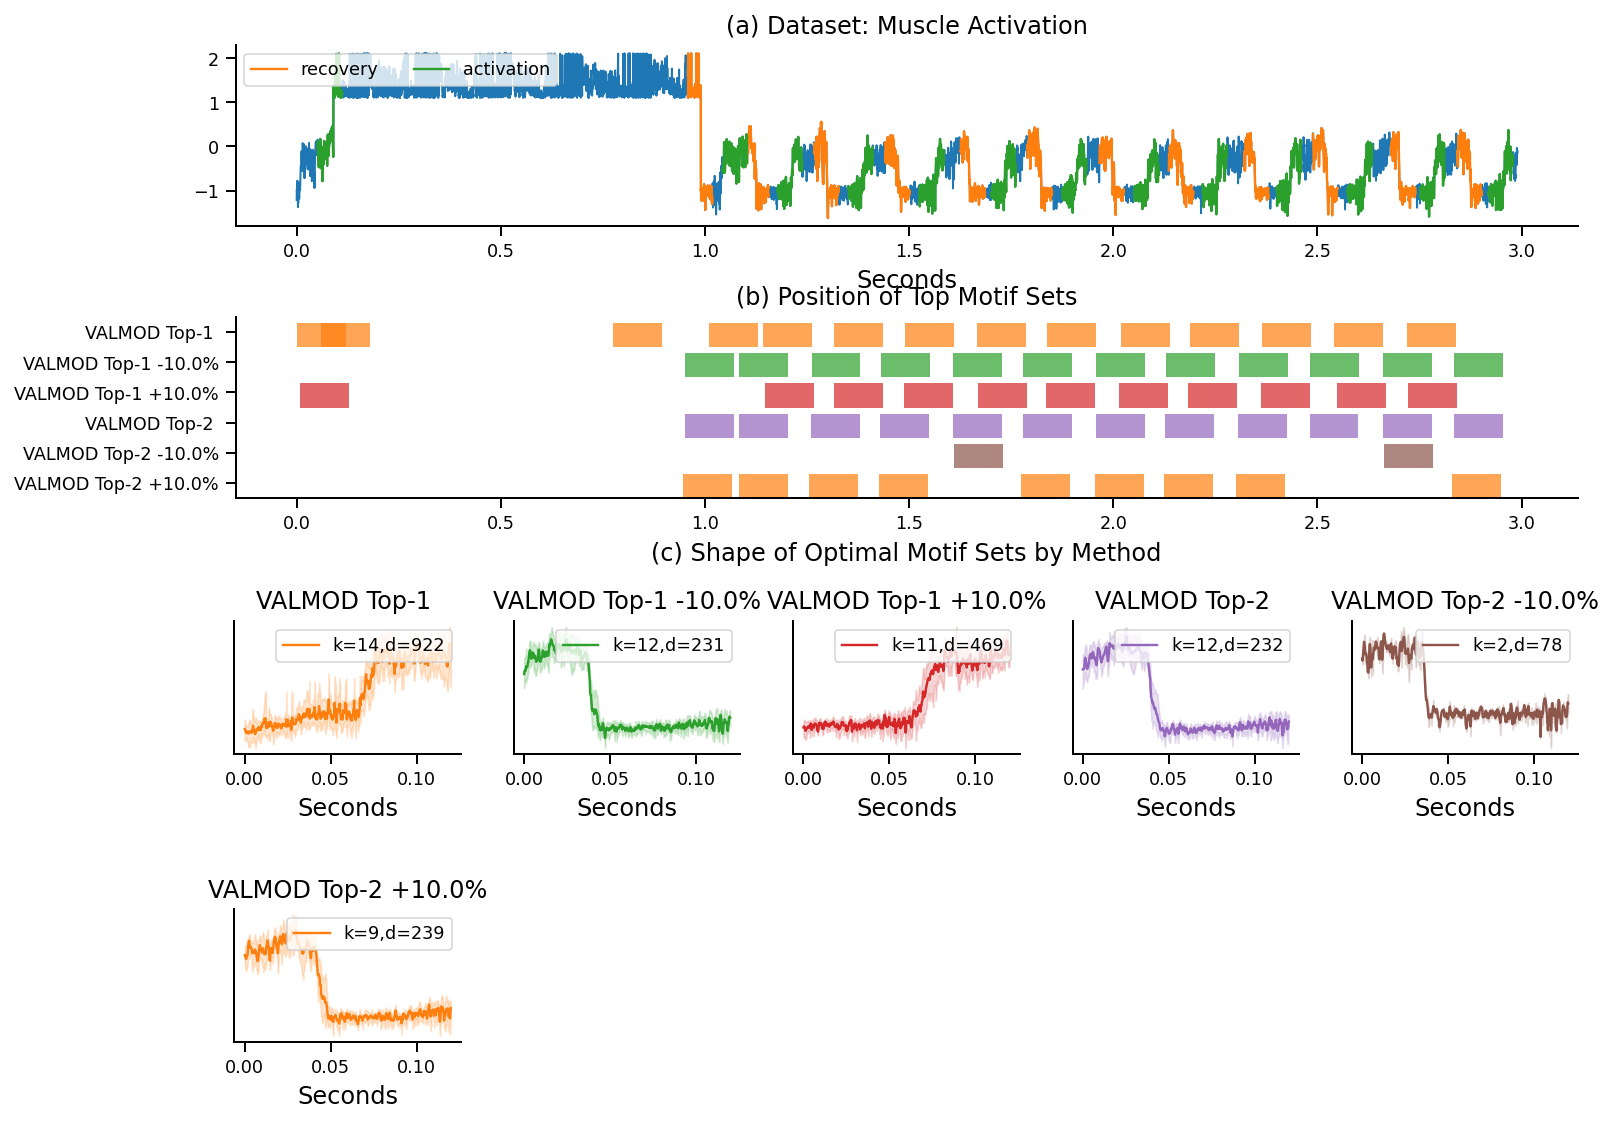

In [13]:
mls = motif_length
max_r=r_top1 * 1.95

df_all_1  = pd.DataFrame()
df_all_2  = pd.DataFrame()

for e in errors:
    rs = max_r * (1.0 * (1+e))
    #mls = np.int32(motif_length * (1-e))
    ms_valmod = list(get_valmod_motif_set_ranged(data, file, mls, max_r=rs))    
    key = format_key(e)
    df_all_1["VALMOD Top-1 " + key ] = [ms_valmod[-1]]
    df_all_2["VALMOD Top-2 " + key ] = [ms_valmod[-2]]

    df["VALMOD Top-1 " + key ] = [ms_valmod[-1]]
    df2["VALMOD Top-2 " + key] = [ms_valmod[-2]]


df_all = (pd.concat([df_all_1, df_all_2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length,
                     method_names=df_all.index.values, ground_truth=df_gt)

# Learning Motifs
See Java Code

In [14]:
rs = np.array([r_top2 * 2.8, r_top1 * 1.3])
mls = motif_length

if rerun_all_jars:
    for e in errors:
        rs = rs * (1.0 * (1+e))
        mls = np.int32(motif_length * (1-e))
        output = subprocess.call(['java', '-jar', 
           '../jars/latent_motifs.jar',
           dataset,
           str(list(rs)),
           str(mls)])

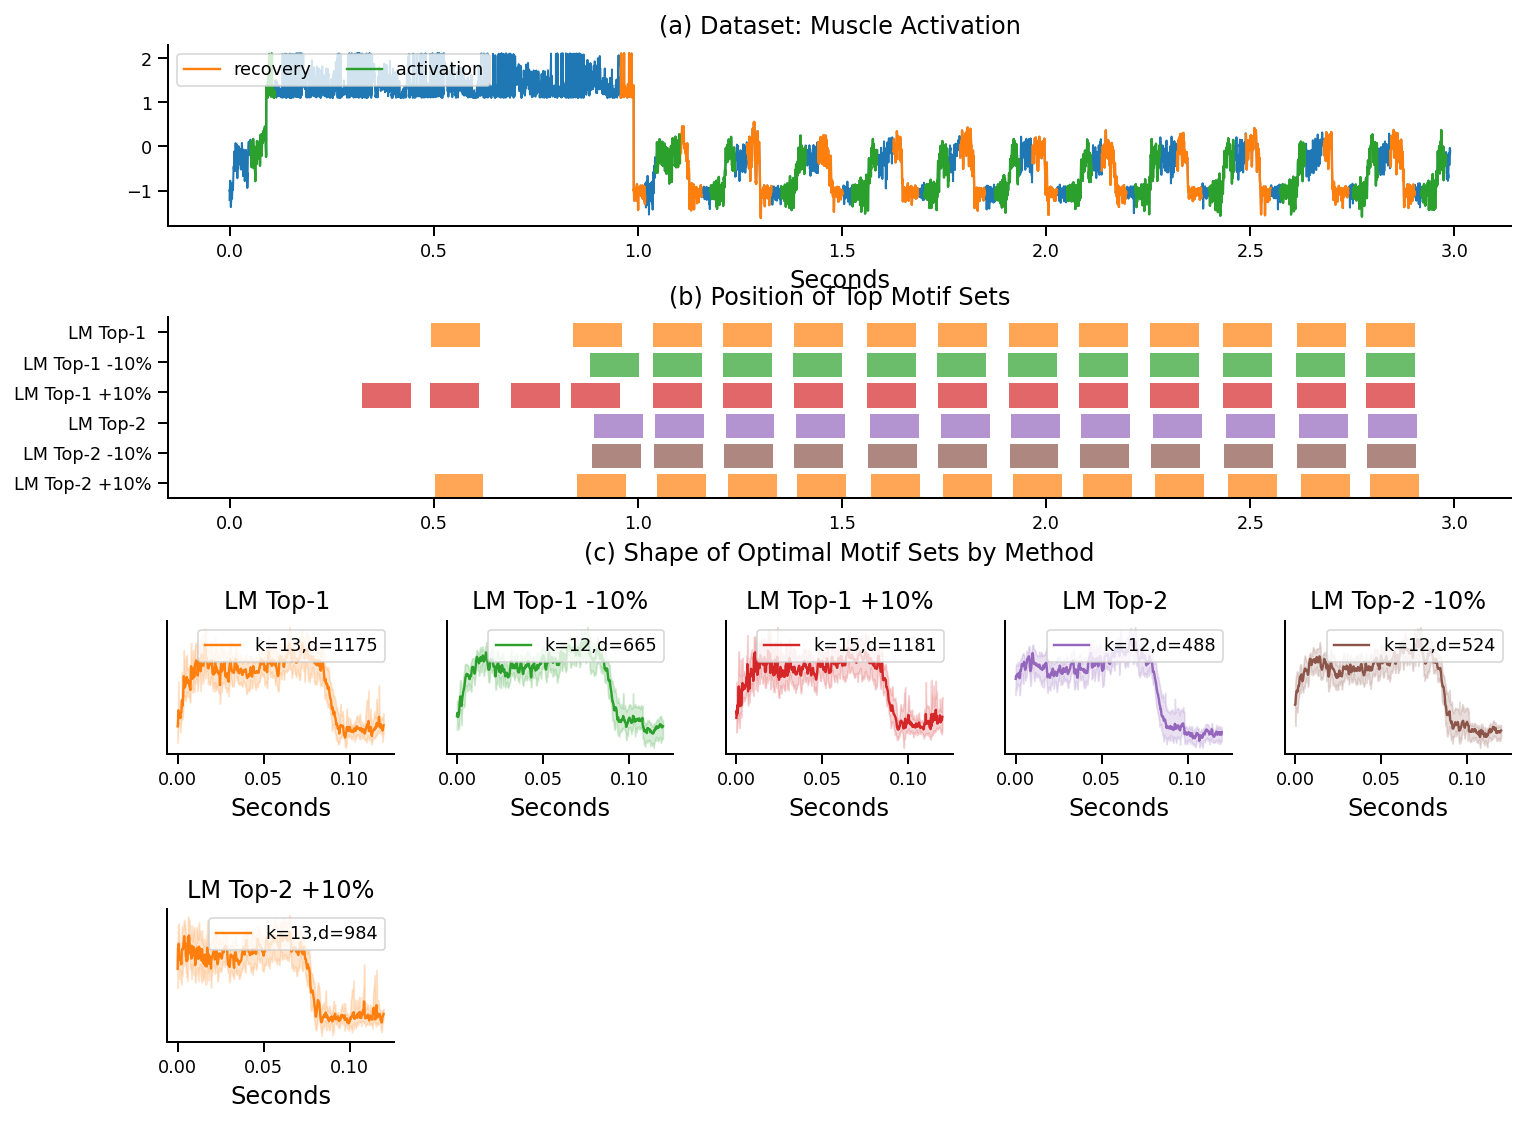

In [15]:
ms_all = {
    "" : [
	[4459,5214,6074,6934,7838,8708,9571,10427,11307,12202,13097,13946,],
	[2472,4209,5183,6045,6910,7810,8675,9540,10404,11268,12165,13068,13918,],
    ], 
    "-10%" : [    
	[4444,5195,6061,6918,7817,8681,9552,10411,11288,12178,13075,13929,],
	[4410,5181,6046,6904,7805,8666,9536,10399,11268,12162,13062,13915,],
    ],        
    "+10%" : [
    [2510,4252,5234,6101,6950,7857,8737,9596,10449,11332,12230,13126,13969,],
	[1620,2453,3446,4181,5183,6045,6911,7809,8674,9542,10404,11271,12165,13068,13919,],        
    ],
}

# run jave code first       
df_all_1  = pd.DataFrame()
df_all_2  = pd.DataFrame()
for key in ms_all:       
    ms_learning_motifs = ms_all[key]
    df_all_1["LM Top-1 " + key] = [ms_learning_motifs[-1]]
    df_all_2["LM Top-2 " + key] = [ms_learning_motifs[-2]]

    df["LM Top-1 " + key] = [ms_learning_motifs[-1]]
    df2["LM Top-2 " + key] = [ms_learning_motifs[-2]]


    
df_all = (pd.concat([df_all_1, df_all_2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)
df_all


motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, 
                     method_names=df_all.index.values, ground_truth=df_gt)

# Comparison

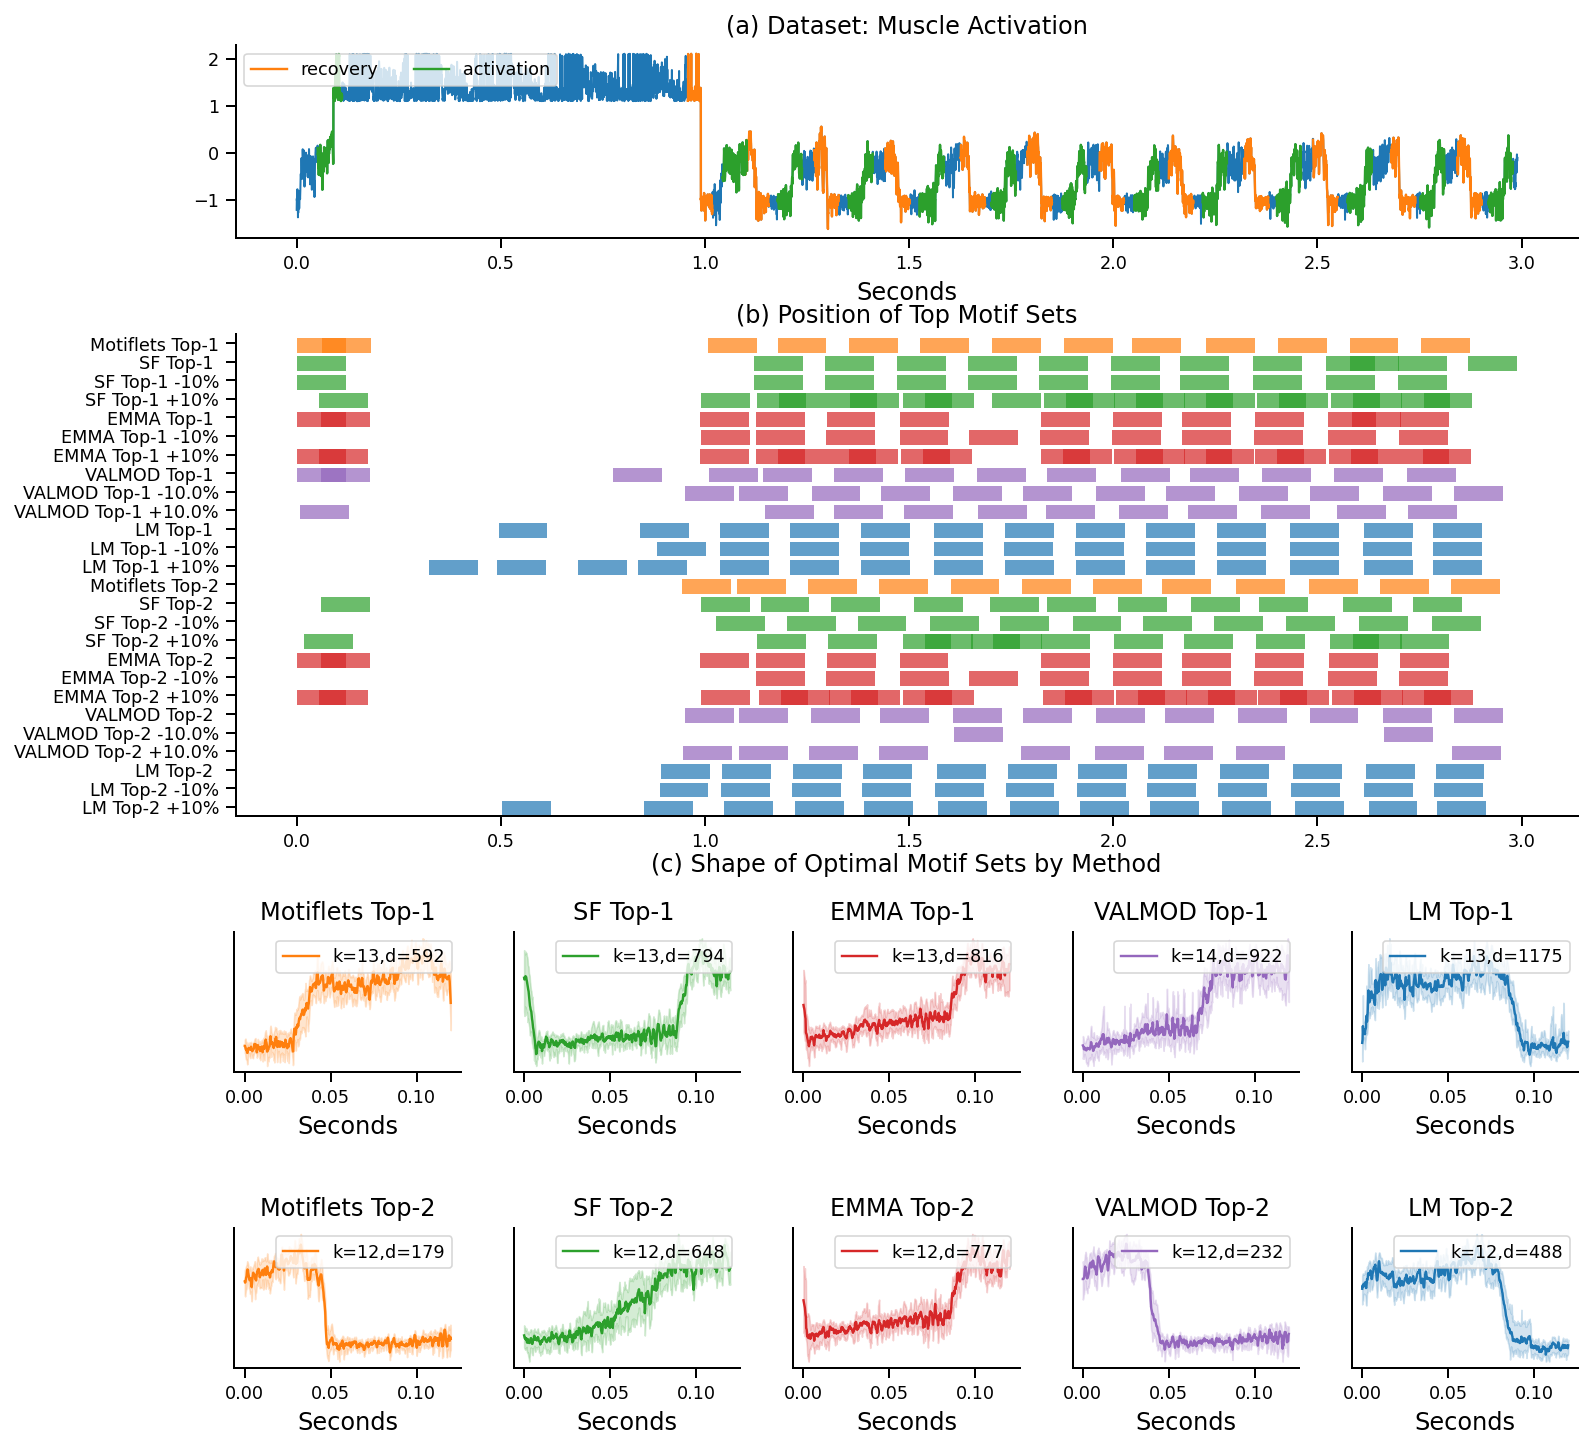

In [18]:
df_all = (pd.concat([df, df2], axis=1)).T
df_all.rename(columns={0:"offsets"}, inplace=True)

index = np.array([0, 1, 2, 3, 4])
color_palette=np.array(sns.color_palette())[index]
plot_index=[0, 1, 4, 7, 10, 13, 14, 17, 20, 23]

motifsets = np.array(df_all["offsets"].values)
plot_all_competitors(series, ds_name, motifsets, motif_length, color_palette=color_palette,
                     method_names=df_all.index.values, ground_truth=df_gt, plot_index=plot_index)            